Basket testing with layer1 coins, trading on btc

In [1]:
from dotenv import load_dotenv
from binance.client import Client as bnb_client
import os

load_dotenv()
# need TLD in US if US
client = bnb_client(tld='US', api_key=os.getenv('BINANCE_API'), api_secret=os.getenv('BINANCE_SECRET'))

In [2]:
all_binance_symbols =[symbol['symbol'] for symbol in client.get_exchange_info()['symbols']]
print(len(all_binance_symbols))

all_usdt_pairs = [symbol['symbol']  for symbol in client.get_exchange_info()['symbols'] if symbol['quoteAsset'] == 'USDT']
len(all_usdt_pairs)

551


178

In [3]:

import datetime
import pandas as pd 
import numpy as np 

def get_binance_px(symbol,freq,start_ts = '2020-01-01'):
    data = client.get_historical_klines(symbol,freq,start_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.datetime.fromtimestamp(x/1000, datetime.timezone.utc))
    data['close_time'] = data['close_time'].map(lambda x: datetime.datetime.fromtimestamp(x/1000, datetime.timezone.utc))
    return data 

univ = all_binance_symbols

freq = '1h'
filename = 'binance_{freq}_px.pkl'.format(freq=freq)
if filename not in os.listdir():
    px = {}
    for x in univ:
        data = get_binance_px(x,freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
    px.to_pickle(filename)
else:
    px = pd.read_pickle(filename)
ret = px.pct_change()

C:\Users\fujos\AppData\Local\Temp\ipykernel_30756\366739778.py:32: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = px.pct_change()


In [4]:
import requests

def get_layer1_coin_names():
    # Step 1: Define the API endpoint and parameters
    api_url = f'https://api.coingecko.com/api/v3/coins/markets'
    category = 'smart-contract-platform'  # Adjust based on actual category
    per_page = 250
    page = 1
    vs_currency = 'usd'
    order = 'market_cap_desc'
    sparkline = 'false'

    coin_names = []
    coin_ticker = []

    while True:
        params = {
            'vs_currency': vs_currency,
            'category': category,
            'order': order,
            'per_page': per_page,
            'page': page,
            'sparkline': sparkline
        }

        response = requests.get(api_url, params=params)

        if response.status_code != 200:
            print(f"Error: Unable to fetch data (Status Code: {response.status_code})")
            break

        data = response.json()

        if not data:
            # No more data to fetch
            break
        
        # Extract coin names
        for coin in data:
            coin_names.append(coin['name'])
            coin_ticker.append(coin['symbol'])

        print(f"Fetched page {page} with {len(data)} coins.")

        page += 1
    return coin_ticker

layer1_coins = get_layer1_coin_names()
print(f"\nTotal Layer 1 Coins Found: {len(layer1_coins)}")


Fetched page 1 with 250 coins.
Fetched page 2 with 250 coins.
Fetched page 3 with 222 coins.

Total Layer 1 Coins Found: 722


In [5]:
exchange_info = client.get_exchange_info()
binance_base_assets = [x['baseAsset'] for x in exchange_info['symbols']]

In [6]:
layer1_coin = [x.upper() for x in layer1_coins]
layer1_coin = [x for x in layer1_coin if x in binance_base_assets]
len(layer1_coin)

83

In [7]:
binance_layer1_symbols = [x['symbol'] for x in exchange_info['symbols'] if (x['baseAsset'] in layer1_coin and x['quoteAsset'] == 'USDT')]
binance_layer1_symbols = [x for x in binance_layer1_symbols if x in ret.columns]
layer1_binance_ret = ret[binance_layer1_symbols]

In [8]:
def compute_to_sharpe(weightings, ret, th = 1, to_off = False):
    to = weightings.diff().abs().sum(1)
    port_ret = (weightings.shift(th) * ret).sum(1)
    bps = .0020
    if to_off:
        bps = 0
    port_ret = port_ret - bps * to
    print("Average Turnover: ", to.mean())
    print("Sharpe Ratio: ", np.sqrt(24*365) * port_ret.mean() / port_ret.std())
    port_ret.cumsum().plot()

    

Signal

Each hour, buy losing coins within the industry, and sell a basket of the most correlated in industry above 0.3 with equal weighting
or do the opposite

PARAMETERS:
 - number of coins to buy/sell without basket
 - buy winner or loser?
 - basket weighitngs/choosing parameters (what stocks, weightings of basket portfolio)
 - time horizon
 - when to trade

RESULTS:
- BASIC REVERSAL Buying/selling loser/winner in 1h time horizon: to - 0.5, sharpe: -3
- best basic reversal rank weightng: to - 0.02-0.06, sharpe - 11(drawdown duration is almost a year and drawdown ~50%)
    - did grid search
- Buy loser sell 10 coins equal weighted that are most correlated with loser: to - 1.1, sharpe = -17 (basketn = 10, lookback = 24)
    - basketn = 5, lookback = 48: to - 1.3, sharpe = -17
    - basketn = 5, lookback = 72: to - 1.3, sharpe = -17
- momentum in gridsearch lokoback/th doesnt work


In [9]:
def rank_weighting(ret, lookback= 1):
    '''rank weighting of returns in the lookback period'''
    ranked_ret = ret.rank(axis=1, pct=True)-0.5
    ranked_ret = ranked_ret.rolling(lookback).mean()
    return ranked_ret.div(ranked_ret.abs().sum(axis=1),axis=0)

def rank_threshold_weighting(df, threshold = 0.8):
    '''rank weighting with threshold'''
    def threshold_f(x, threshold = threshold):
        x = x.rank(pct=True)
        x = x.map(lambda x: 0 if 1-threshold < np.abs(x) < threshold else x-0.5)
        x = x.divide(x.abs().sum())
        return x
    df = df.apply(threshold_f, axis = 1)
    return df

def reversal_weightings(ret):
    '''portfolio weightings based on signal weightings for reversal strategy'''
    # set max to -0.5 and min to 0.5
    def transform_row(row):
        max_val = row.max()
        min_val = row.min()
        return row.map(lambda x: -0.5 if x == max_val else (0.5 if x == min_val else 0))

    def long_short_basket(ret, lookback = 72, number_stock_basket = 10, buyorsell = 'buy'):
        '''long short basket of stocks based on correlation'''
        f = lambda x: x.idxmin()
        multiplier = 1
        if buyorsell == 'sell':
            f = lambda x: x.idxmax()
            multiplier = -1
        buysell_coin = ret.apply(f, axis = 1).dropna()
        
        rolling_corrs = ret.rolling(lookback)
        rolling_corrs = rolling_corrs.apply(lambda x: x.corr(x[buysell_coin[x.name]]))

        print(rolling_corrs)

    ret = long_short_basket(ret)
    return ret.apply(lambda x: x / x.abs().sum(), axis=1)


signal = rank_threshold_weighting(layer1_binance_ret)

Average Turnover:  1.6763294101886375
Sharpe Ratio:  -19.180469749092374


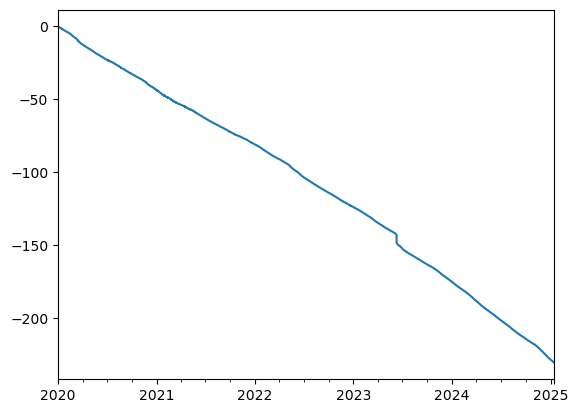

In [11]:
compute_to_sharpe(signal, layer1_binance_ret)

In [15]:
from numba import njit

def long_short_basket(ret, lookback = 24, number_stock_basket = 10, buyorsell = 'buy'):
    '''long short basket of stocks based on correlation'''
    multiplier = 1
    if buyorsell == 'buy':
        buysell_coin = ret.idxmin(axis=1)
    elif buyorsell == 'sell':
        buysell_coin = ret.idxmax(axis=1)
        multiplier = -1
    rolling_corrs = pd.DataFrame(index=ret.index, columns=ret.columns)
    rolling_ret = ret.rolling(window=lookback)

    @njit
    def compute_corr(window1, window2):
        # Remove NaNs
        mask = (~np.isnan(window1)) & (~np.isnan(window2))
        valid_window1 = window1[mask]
        valid_window2 = window2[mask]
        
        if len(valid_window1) < 2:
            return np.nan
        # Compute correlation
        mean1 = valid_window1.mean()
        mean2 = valid_window2.mean()
        std1 = valid_window1.std()
        std2 = valid_window2.std()
        if std1 == 0 or std2 == 0:
            return np.nan
        covariance = ((valid_window1 - mean1) * (valid_window2 - mean2)).sum()
        correlation = covariance / (len(valid_window1) * std1 * std2)
        return correlation
    
    # Step 4: Iterate Over Each Column and Compute Rolling Correlations
    for col in ret.columns:
        col_data = ret[col].values
        corr_values = np.full(len(ret), np.nan)
        
        for i in range(lookback - 1, len(ret)):
            current_time = ret.index[i]
            coin = buysell_coin.get(current_time, np.nan)
            if pd.isna(coin):
                continue
            coin_series = ret[coin].values
            # Define window indices
            window_start = i - lookback + 1
            window_end = i + 1
            window1 = col_data[window_start:window_end]
            window2 = coin_series[window_start:window_end]
            # Compute correlation
            corr = compute_corr(window1, window2)
            corr_values[i] = corr
        
        rolling_corrs[col] = corr_values
    
    def set_weights(row):
        coin = buysell_coin.loc[row.name]
        largest_indices = np.argpartition(-row.values, number_stock_basket+1)[:number_stock_basket + 1]
        mask = np.zeros(len(row), dtype=bool)
        mask[largest_indices] = True
        row[~mask] = 0
        row[mask] = -multiplier/2/number_stock_basket
        row[coin] = multiplier/2
        
        return row
    weights = rolling_corrs.apply(set_weights, axis=1)
    # def get_corr(x):
    #     coin = buysell_coin.loc[x.index[-1]]
    #     return x.corr(ret.loc[:,coin])
    # for col in ret.columns:
    #     rolling_corrs.loc[:,col] = rolling_corrs[col].rolling(lookback).apply(get_corr)
    return weights, rolling_corrs
# temp = long_short_basket(layer1_binance_ret, lookback=72, number_stock_basket=5, buyorsell='sell')

In [16]:
# grid search
def to_sharpe(weightings, ret, th = 1, to_off = False, plot = False):
        weightings = weightings.iloc[::th]
        ret = ret.iloc[::th]
        to = weightings.diff().abs().sum(1)
        port_ret = (weightings.shift(1) * ret.rolling(1).sum()).sum(1)
        bps = .0020
        if to_off:
            bps = 0
        port_ret = port_ret - bps * to
        avg_to = to.mean()
        sharpe = np.sqrt(24*365/th) * port_ret.mean() / port_ret.std()
        drawdown = port_ret.cumsum().cummax() - port_ret.cumsum()
        max_drawdown = drawdown.max()
        drawdown_durations = (drawdown < 0).cumsum()
        durations = drawdown_durations.groupby(drawdown_durations).cumcount()
        max_drawdown_duration = durations.max()
        if plot:
            print("Average Turnover: ", avg_to)
            print("Sharpe Ratio: ", sharpe)
            port_ret.cumsum().plot()
        return avg_to, sharpe, max_drawdown, max_drawdown_duration

def gridsearch(weightings, ret, **kwargs):
    """"
    Lookback is signal speed (e.g 12 means average signal from last 12 hours)
    th is holding period (e.g 8 means rebalance every 8 hours)
    """

    lookback = [1, 12, 24, 48, 96, 168, 336, 672]
    th = [1, 2, 3, 6, 18, 36, 72, 144, 168, 336]
    info = []
    
    for i in lookback:
        for j in th:
            weightings = weightings.rolling(i).mean(i)
            avg_to, sharpe, drawdown, drawdown_duration = to_sharpe(weightings, ret, th = j)
            info.append((i, j, avg_to, sharpe, drawdown, drawdown_duration, kwargs['lookback']))
    return info
lookback =  [1, 2, 4, 8, 16, 24, 48,96, 168, 336]
results = []
for i in lookback:
    kwargs = {'lookback': i}
    info = gridsearch(rank_weighting(layer1_binance_ret, lookback= i ),layer1_binance_ret, **kwargs)
    results += info

In [22]:
pd.DataFrame(results, columns = ['signal_speed','holding_period','avg_to','sharpe', "drawdown", "drawdown_duration",'rank_lookback']).sort_values('sharpe',ascending=False).where(lambda x: x['avg_to'] > 0.01).dropna().head(30)

,signal_speed,holding_period,avg_to,sharpe,drawdown,drawdown_duration,rank_lookback
590,48.0,1.0,0.010259,1.182368,1.116773,44154.0,96.0
510,48.0,1.0,0.011735,1.176611,1.053039,44154.0,48.0
660,24.0,1.0,0.010751,1.020800,1.633268,44154.0,168.0
227,336.0,144.0,0.011218,0.963382,0.013838,306.0,4.0
307,336.0,144.0,0.016638,0.951889,0.019595,306.0,8.0
387,336.0,144.0,0.023904,0.938288,0.027071,306.0,16.0
467,336.0,144.0,0.029023,0.931812,0.033393,306.0,24.0
547,336.0,144.0,0.038925,0.898823,0.045561,306.0,48.0
627,336.0,144.0,0.049795,0.870644,0.056794,306.0,96.0
752,48.0,3.0,0.011462,0.858098,1.034064,14718.0,336.0


In [24]:
def ma(weightings, lookback = 24):
    return weightings.rolling(lookback).mean().apply(lambda x: x / x.abs().sum(), axis=1)

def to_sharpe(weightings, ret, th = 1, to_off = False, plot = False, return_ret = False):
        weightings = weightings.iloc[::th]
        ret = ret.iloc[::th]
        to = weightings.diff().abs().sum(1)
        port_ret = (weightings.shift(1) * ret.rolling(1).sum()).sum(1)
        bps = .0020
        if to_off:
            bps = 0
        port_ret = port_ret - bps * to
        if return_ret:
            return port_ret
        avg_to = to.mean()
        sharpe = np.sqrt(24*365/th) * port_ret.mean() / port_ret.std()
        drawdown = port_ret.cumsum().cummax() - port_ret.cumsum()
        max_drawdown = drawdown.max()
        drawdown_durations = (drawdown < 0).cumsum()
        durations = drawdown_durations.groupby(drawdown_durations).cumcount()
        max_drawdown_duration = durations.max()
        if plot:
            print("Average Turnover: ", avg_to)
            print("Sharpe Ratio: ", sharpe)
            port_ret.cumsum().plot()
        return avg_to, sharpe, max_drawdown, max_drawdown_duration

In [27]:
to_sharpe(ma(rank_weighting(layer1_binance_ret, lookback = 48), lookback=96),layer1_binance_ret, th = 1, plot = True, return_ret=True).corr(layer1_binance_ret['BTCUSDT'])

0.7197973477921992